<h1>
  <center>
    Differential evolution with
  </center>
  <center>
    adaptive mutation and crossover strategies
  </center>
</h1>

## What is differential evolution (DE)?
Differential Evolution (DE) is a population-based stochastic optimization algorithm introduced by Storn and Price in 1997. Designed for continuous optimization problems, DE is particularly effective for nonlinear, non-differentiable, and multimodal objective functions.
  
DE belongs to the family of Genetic Algorithms, and has three main operations: **mutation**, **crossover**, and **selection**.  

The algorithm works with a population of vectors $x_i = [x_{ij}]$, with $i = 1, 2, 3, ...,NP$ and $j = 1, 2, 3, ..., D$.  
Upon initialization, these vectors have a random value within a specified interval. Next, the population changes with each generation according to the three main operations.  

In the mutation operation, the mutant vector $xm$ for the target vector $x_i$ is generated by:
$$ xm = x_{r1} + F(x_{r2} − x_{r3} ) $$
where $r1$, $r2$, and $r3$ are random distinct indices between $1$ to $NP$ and also different from i, and F is a scaling factor.  

Next, the crossover operation creates the trial vector xc using the crossover rate CR as:
$$ xc_{j} = \begin{cases}
      xm_{j} & \text{if } (rand_j \leq CR) \text{ or } (j = j_{\text{rand}}) \\
      x_{i,j} & \text{otherwise}
   \end{cases} $$
where $rand_j$ is a uniform random number in $[0, 1]$ for each $j = 1, 2, 3, ..., D$ and $IC$ is a randomly fixed index from $1$ to $D$.  

In the selection part, trial vector $xc$ and the target vector $x_i$ are compared in the selection operation. The vector $xc$ replaces $xi$ when $f(xc) < f(x_i)$. It also updates $xb$ and $fb$ when $f(xc) < fb$.  

Pseudocode:
```python
1. Initialize population P = {x₁, x₂, ..., x_NP} randomly within bounds
2. While stopping criterion not met:
   3. For each target vector x_i in P:
      4. Mutation: Generate mutant vector v = x_r₁ + F · (x_r₂ - x_r₃)
      5. Crossover: Create trial vector u by mixing x_i and v (binomial crossover)
      6. Selection: Replace x_i with u if f(u) < f(x_i)
   7. Update best solution x_best
8. Return x_best
```

## DE implementation in Python

In [23]:
# Import NIST models
import sys
sys.path.append("../")
from nist_models.models.nist_models import NISTModel

# Import other useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Helper functions for the DE algorithm applied to the NIST problem

def residual_sum_squares(params, x_data, y_data, model_func, max_val=1e100):
  """
    Compute the Residual Sum of Squares (RSS) for a nonlinear regression model
    Input:
      - params: array-like (model parameters to evaluate, e.g. [b1, b2, ..., bD])
      - x_data: array-like (input of observations)
      - y_data: array-like (output of observations)
      - model_func: callable (function that computes the model predictions)
    Output:
      - float: RSS = sum((y_data - model_prediction)^2)
  """
  # Compute model predictions for given parameters
  y_pred = model_func(x_data, *params)
  
  # Calculate residuals (difference between observed and predicted)
  residuals = y_data - y_pred
  residuals = np.clip(residuals, -max_val, max_val) # Prevent overflow
  
  # Return sum of squared residuals
  return np.sum(residuals ** 2)

def get_nist_bounds(certified_values, k=10, default_low=0, default_high=100):
  """
    Generate possible bounds for NIST problems based on certified values.
    Input:
      - certified: np.array (certified parameter values)
      - k: float (multiplier for bounds)
      - default_low: float (default lower bound if certified value is zero)
      - default_high: float (default upper bound if certified value is zero)
    Output:
    - 
  """
  bounds = []
  for val in certified_values:
    if val == 0:
      bounds.append((default_low, default_high))
    else:
      L = val / k
      U = val * k
      bounds.append((min(L, U), max(L, U)))  # Handle negative values
  return bounds

def initialize_population(NP, D, bounds):
  """
    Initialize a list of NP vectors (dimension D) with random values from the interval described by bounds
    Input:
      - NP: int (population size)
      - D: int (problem dimension)
      - bounds: list[tuple(float, float)] (lower and upper bounds for each parameter)
    Output:
      - population: np.ndarray (population matrix of shape (NP, D).
  """
  population = np.zeros((NP, D))

  # Uniform random initialization within bounds
  for j in range(D):
    L_j, U_j = bounds[j]
    population[:, j] = np.random.uniform(L_j, U_j, size=NP)
  
  return population

def mutation_operation(target_idx, population, F):
  """
   Perform mutation on a target vector
    Input:
      - target_idx:  int (index of the target vector in the population)
      - population: np.ndarray (current population (shape: [NP, D]))
      - F: float (scaling factor)
    Output:
      - xm: np.ndarray (mutant vector)
  """
  NP, D = population.shape
  target = population[target_idx]
  
  # Select three distinct random indices != target_idx
  candidates = [i for i in range(NP) if i != target_idx]
  r1, r2, r3 = np.random.choice(candidates, 3, replace=False)

  # Generate mutant vector
  xm = population[r1] + F * (population[r2] - population[r3])
  return xm

def crossover_operation(target, mutant, CR):
  """
    Perform crossover between target and mutant vector
    Input:
      - target: np.array (target vector (shape: [D]))
      - mutant: np.array (mutant vector (shape: [D]))
      - CR: float (crossover rate (dynamically selected from [0,0.1] or [0.9,1]))
    Output:
      - trial: np.array (trial vector (shape: [D]))
  """
  D = len(target)
  trial = np.zeros(D)
  
  # Randomly select a fixed index to ensure at least one parameter changes
  IC = np.random.randint(0, D)
  
  for j in range(D):
    if (np.random.rand() < CR) or (j == IC):
      trial[j] = mutant[j]  # Take from mutant
    else:
      trial[j] = target[j]  # Take from target
  
  return trial

In [35]:
# DE algorithm for the NIST problem

def differential_evolution(f, D, bounds, F = 0.5, CR = 0.9, eps = 1e-10):
  """
    Implements the differential evolution algorithm
    Input:
      - f: lambda function (objective function to be minimized)
      - D: int (problem dimension)
      - bounds: list[tuple(float, float)] (lower and upper bounds for each parameter)
      - F: float (scaling factor)
      - CR: float (crossover rate)
    Output:
      - xb: np.array (best configuration)
      - fb: float (best fitness value)
      - converged: boolean (measures if the algorithm converged before reaching maximum evaluations)
  """
  # Initialize control parameters
  NP = 10 * D # Population size
  nf = 0 # Number of function evaluations
  maxnf = 40000 * D # Maximum number of function evaluations
  converged = False

  # Initialize list of population vectors
  population = initialize_population(NP, D, bounds)

  # Find initial best and worst
  fb = float('inf')
  fw = -float('inf')
  for i, x in enumerate(population):
    fx = f(x)
    nf += 1
    if fx < fb:
      xb, fb = x.copy(), fx
    if fx > fw:
      xw, fw = x.copy(), fx
  
  # Stopping condition
  while not np.log((fw + 1e-300)/(fb + 1e-300)) < eps and nf < maxnf:
    # Generate new population
    for i in range(NP):
      # Select target vector
      x = population[i]
      fx = f(x)
      
      # Mutate vector
      xm = mutation_operation(i, population, F)
      xm = np.clip(xm, [b[0] for b in bounds], [b[1] for b in bounds])

      # Crossover vector
      xc = crossover_operation(x, xm, CR)

      # Selection
      fc = f(xc)
      nf += 1
      if fc < fx:
        # Replace target with trial
        population[i] = xc
      
        # Update global best solution
        if fc < fb:
          xb, fb = xc.copy(), fc

    # Update worst value
    fw = max(f(x) for x in population)
    
    # Early stopping if converged
    if np.log(fw/fb) < eps:
      converged = True
      break

  return xb, fb, nf, converged
    
def de_nist_model(model_name: str):
  """
    Applies the differential evolution with adaptive mutation and crossover strategy algorithm
    for a certain NIST nonlinear least squares regression model based on its name
    Input:
      - model_name: str (name of NIST model for nonlinear regression)
  """
  model = NISTModel(model_name)
  model_func = model.model()
  data = model.data()
  rss = lambda x: residual_sum_squares(x, np.array(data['x']), np.array(data['y']), model_func)
  D = model.get_parameters_count()
  bounds = get_nist_bounds(model.get_certified_values())

  return differential_evolution(rss, D, bounds)

## Evaluate performance of algorithm on NIST models

### Plot generated regression functions

Lower difficulty models:


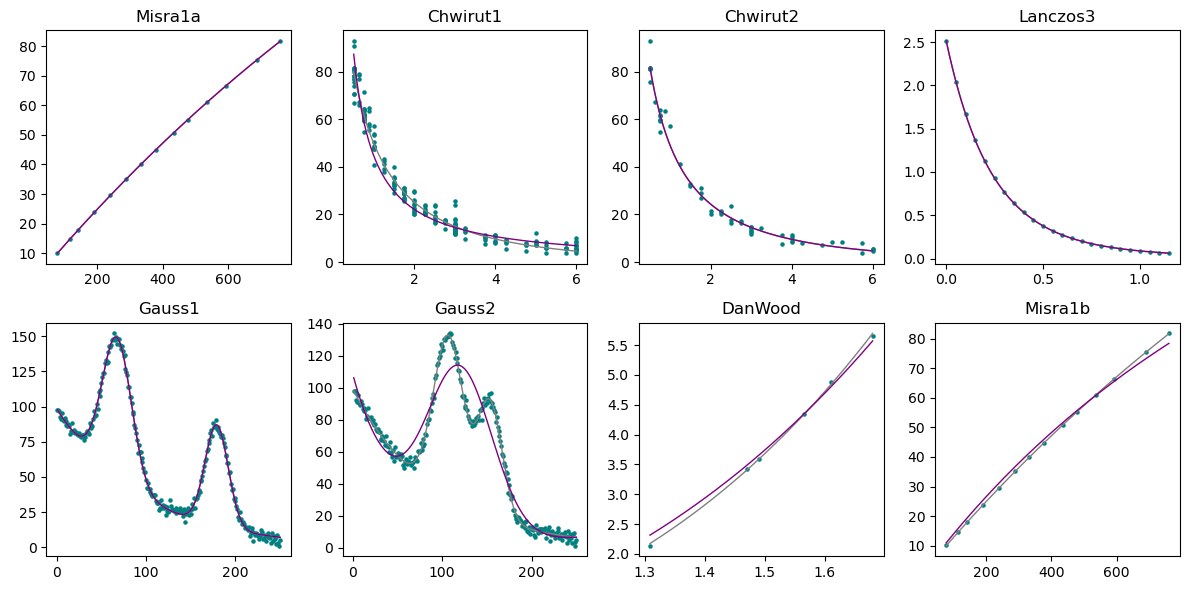

Average difficulty models:


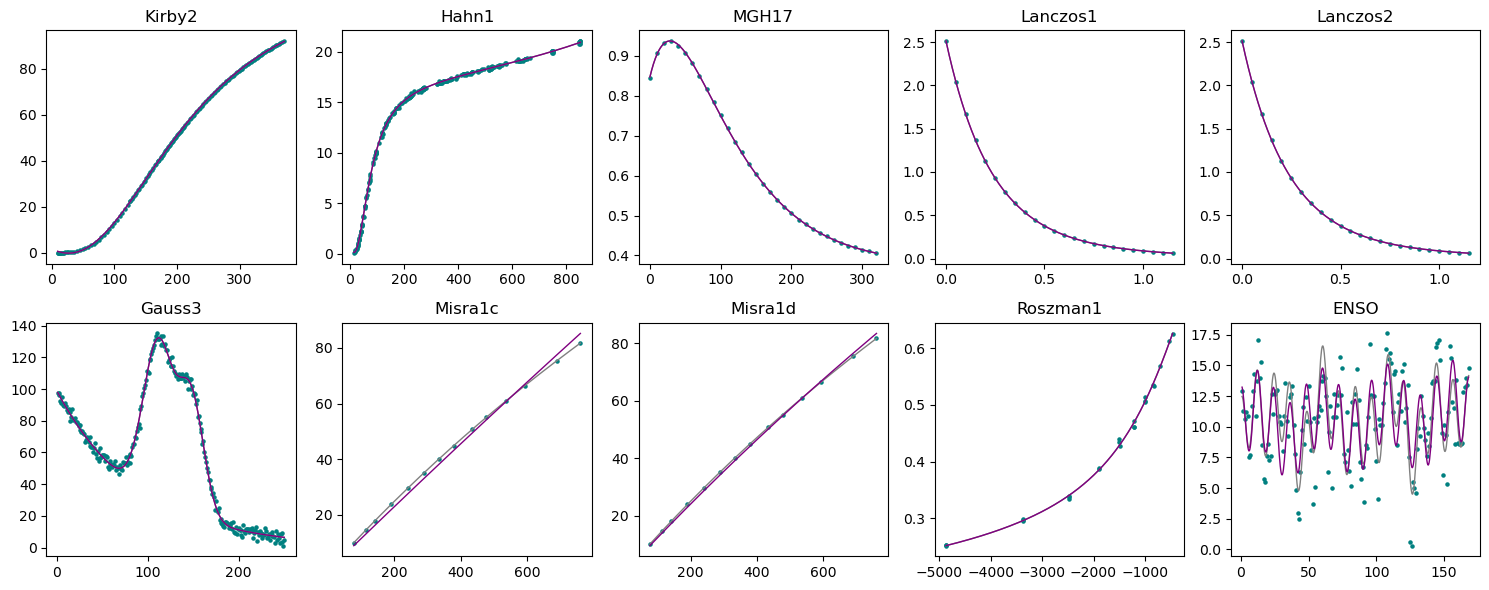

Higher difficulty models:


<string>:1: RuntimeWarning: overflow encountered in exp


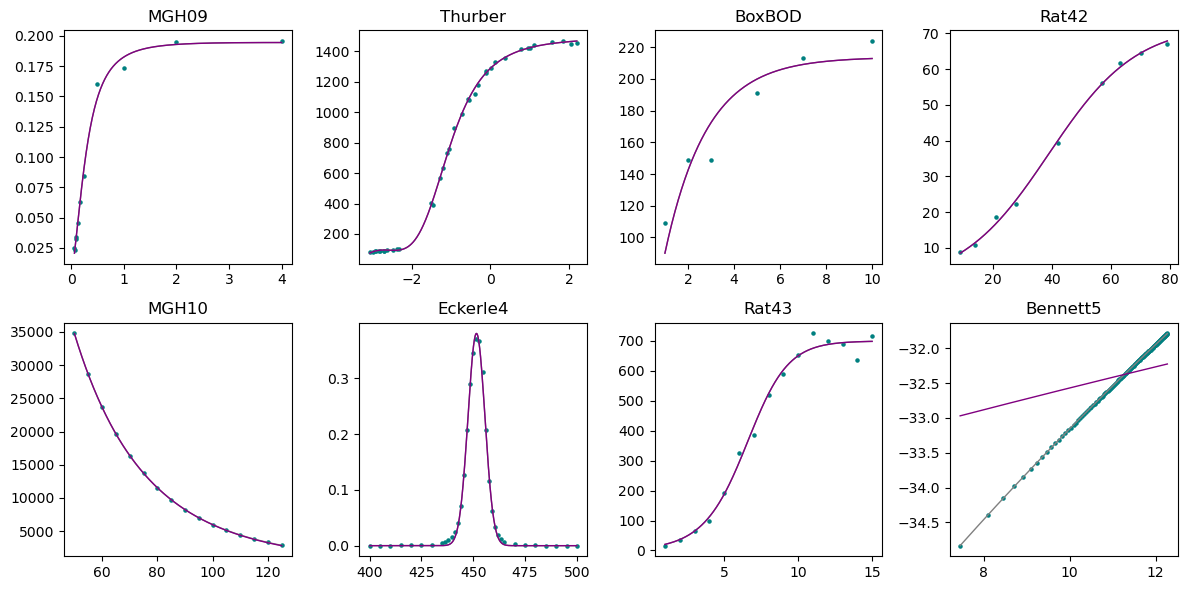

In [36]:
# Plot graphs of functions generated by the DE algorithm for the NIST models

model_names = [
  # Lower difficulty
  ["Misra1a", "Chwirut1", "Chwirut2", "Lanczos3", "Gauss1", "Gauss2", "DanWood", "Misra1b"],
  # Average difficulty
  ["Kirby2", "Hahn1", "MGH17", "Lanczos1", "Lanczos2", "Gauss3", "Misra1c", "Misra1d", "Roszman1", "ENSO"],
  # Higher difficulty
  ["MGH09", "Thurber", "BoxBOD", "Rat42", "MGH10", "Eckerle4", "Rat43", "Bennett5"]
]
model_difficulties = ["Lower", "Average", "Higher"]
deamc_results = [[], [], []]

for batch in range(3):
  print(f"{model_difficulties[batch]} difficulty models:")
  if batch == 1:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  else:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

  for ax, title in zip(axes.flat, model_names[batch]):
    model = NISTModel(title)
    model_df = model.data()

    # Apply DEAMC algorithm to model
    xb, fb, nf, c = de_nist_model(title)
    deamc_results[batch].append((title, xb, fb, nf, c))

    # Plot model function with certified parameters
    x = np.linspace(min(model_df['x']), max(model_df['x']), 500)
    f = np.zeros(500)
    for i in range(500):
      f[i] = model.evaluate(x[i], model.get_certified_values())
    ax.plot(x, f, linewidth=1, color='grey')
    # Plot function generated by DEAMC
    f_deamc = np.zeros(500)
    for i in range(500):
      f_deamc[i] = model.evaluate(x[i], xb)
    ax.plot(x, f_deamc, linewidth=1, color='purple')
    # Plot observations
    ax.scatter(model_df['x'], model_df['y'], s=5, color='teal')
    ax.set_title(title)
  
  plt.tight_layout()
  plt.show()

### Evaluating convergence and experimental results
Next, I will perform experiments to compute the performance of the DE algorithm on the selected datasets.  
To be able to compare my algorithm's performance to that of Wongsa, Puphasuk and Wetweerapong, I will perform 10 experiments for every model, and compute the following metrics:  
Let $fb$ be the best value obtained from an algorithm and $c$ be the certified value for a problem.  
- $\lambda$ value indicates the number of decimal places that fb matches the certified value
$$ \lambda = \begin{cases} 
    0 & \text{if } \frac{|fb - c|}{c} \geq 1 \\
    11 & \text{if } \frac{|fb - c|}{c} < 10^{-11} \\
    -\log_{10}\left(\frac{|fb - c|}{c}\right) & \text{otherwise}
  \end{cases} $$
- $NS$ is the number of successful runs, calculated as the number of runs where:
  - the algorithm reaches the threshold before exceeding the $maxnf$ (early convergence)
  - $\lambda > 4$
- Mean $nf$ represents the average number of evaluations of the algorithm over the 100 experiments.

In [38]:
# Metrics functions

def compute_lambda(fb, c, eps=1e-16):
  """Compute lambda metric (log10 of relative error)."""
  rel_error = np.linalg.norm(fb - c) / (np.linalg.norm(c) + eps)
  if rel_error >= 1:
    return 0
  elif rel_error < 1e-11:
    return 11
  else:
    return -np.log10(rel_error)

def success(convergence, lamb, threshold=4):
  """Determine if a run is successful."""
  return convergence and (lamb >= threshold)

def de_10_experiments(model_name: str):
  """
  Run 10 DE experiments for a NIST model and return metrics:
  - NS: Number of successful runs (lamb >= 4 and converged)
  - mean_nf: Mean number of function evaluations
  - mean_lambda: Mean lambda (accuracy) across runs
  """
  model = NISTModel(model_name)
  certified_values = model.get_certified_values()
  NS = 0
  nf_values = []
  lambda_values = []

  for _ in range(10):
    xb, fb, nf, converged = de_nist_model(model_name)
    lamb = compute_lambda(xb, certified_values)
    
    nf_values.append(nf)
    lambda_values.append(lamb)
    if success(converged, lamb):
      NS += 1

  mean_nf = np.mean(nf_values) if nf_values else 0
  mean_lambda = np.mean(lambda_values) if lambda_values else 0
  return NS, mean_nf, mean_lambda

In [39]:
# Generate markdown tables from data

def lists_to_markdown_table(header, *lists):
  '''
    Returns a string formatted like a markdown table which contains data from the header and the lists
    Input:
      - header: string
      - *lists: varying number of list[] -> size = n
    Output:
      - markdown_table: string
  '''
  markdown_table = header
  n = len(lists[0])
  for i in range(n):
    markdown_table += "|"
    for list in lists:
      markdown_table += f" {list[i]} |"
    markdown_table += "\n"
  return markdown_table

In [41]:
# Compute metrics for the algorithms and store them in markdown tables

model_names = [
  # Lower difficulty
  ["Misra1a", "Chwirut1", "Chwirut2", "Lanczos3", "Gauss1", "Gauss2", "DanWood", "Misra1b"],
  # Average difficulty
  ["Kirby2", "Hahn1", "MGH17", "Lanczos1", "Lanczos2", "Gauss3", "Misra1c", "Misra1d", "Roszman1", "ENSO"],
  # Higher difficulty
  ["MGH09", "Thurber", "BoxBOD", "Rat42", "MGH10", "Eckerle4", "Rat43", "Bennett5"]
]
tables = []

for batch in range(3):
  model_names_values = model_names[batch]
  NS_list = []
  mean_nf_list = []
  mean_lambda_list = []

  for model_name in model_names_values:
    NS, mean_nf, mean_lambda = de_10_experiments(model_name)

    NS_list.append(NS)
    mean_nf_list.append(mean_nf)
    mean_lambda_list.append(mean_lambda)

  header = "| Problem | NS | Mean nf | Mean λ |\n"
  header += "|---|---|---|---|\n"
  table = lists_to_markdown_table(header, model_names_values, NS_list, mean_nf_list, mean_lambda_list)
  tables.append(table)

## Table of obtained experimental results

### Lower difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Misra1a | 2 | 4164.0 | 1.7555488168340212 |
| Chwirut1 | 10 | 2478.0 | 5.897134335199854 |
| Chwirut2 | 10 | 2442.0 | 6.378852029451933 |
| Lanczos3 | 0 | 190446.0 | 0.4052957771322845 |
| Gauss1 | 2 | 27768.0 | 1.4837352152653824 |
| Gauss2 | 2 | 46600.0 | 1.5596260997156304 |
| DanWood | 8 | 1638.0 | 6.573395777394046 |
| Misra1b | 1 | 2776.0 | 1.0578508566795333 |

### Average difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Kirby2 | 10 | 12065.0 | 6.436873232375002 |
| Hahn1 | 10 | 27188.0 | 5.910902660293525 |
| MGH17 | 10 | 79700.0 | 5.915919088614826 |
| Lanczos1 | 0 | 196614.0 | 0.49620989375469715 |
| Lanczos2 | 0 | 126990.0 | 0.21269850701918963 |
| Gauss3 | 2 | 46552.0 | 1.5345681433867706 |
| Misra1c | 0 | 3100.0 | 0.08132135978868593 |
| Misra1d | 0 | 4286.0 | 0.0 |
| Roszman1 | 10 | 5712.0 | 6.572049048247081 |
| ENSO | 3 | 22860.0 | 1.8825562365526924 |

### Higher difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| MGH09 | 10 | 6820.0 | 5.782897348747774 |
| Thurber | 3 | 37667.0 | 2.1953250239134587 |
| BoxBOD | 8 | 1926.0 | 6.255656064450951 |
| Rat42 | 9 | 4551.0 | 6.813147683753497 |
| MGH10 | 0 | 53637.0 | 0.8565139914259581 |
| Eckerle4 | 7 | 4059.0 | 6.602850393161925 |
| Rat43 | 10 | 6452.0 | 7.303960233344874 |
| Bennett5 | 0 | 28752.0 | 0.17725060761201067 |

## Improving differential evolution – DEAMC algorithm
The classical DE algorithm, although very powerful on its own, has a few limitations:
- Fixed mutation and crossover strategies
  - Poor exploration vs. exploitation trade-off
- Static values for scaling factor (F) and crossover rate (CR)
  - Requires manual tuning for each problem.
- Premature Convergence
  - May stagnate in local optima for complex, multimodal functions.  

To the problems above, the DEAMC algorithm proposes the following solutions:
1. Adaptive Mutation: dynamically switch between Classic Mutation (CM) and Sorting Mutation (SM) based on success rates.
2. Dynamic Crossover: alternate between low (CR ∈ [0, 0.1]) and high (CR ∈ [0.9, 1]) crossover ranges.
3. Self-Tuning Probabilities: automatically adjust strategy probabilities (pm1, pc1) using success histories.

Pseudocode:
```python
1. Initialize:
  - Population P = {x₁, x₂, ..., x_NP} within bounds (NP = 10D)
  - Probabilities: pm1 = pm2 = 0.5 (CM/SM), pc1 = pc2 = 0.5 (low/high CR)
  - Counters: nm1 = nm2 = 0 (CM/SM successes), nc1 = nc2 = 0 (CR successes)
2. While stopping criterion not met (log(fw/fb) < ε or nf ≥ maxnf):
  3. For each target vector x_i in P:
    4. Mutation:
      - Generate F ~ U[0.5, 0.7]
      - With probability pm1:  
        v = x_r₁ + F · (x_r₂ - x_r₃)
      - Else:  
        Sort {x_r₁, x_r₂, x_r₃} by fitness (ascending) → {x*_r₁, x*_r₂, x*_r₃}  
        v = x*_r₁ + F · (x*_r₂ - x*_r₃)
    5. Crossover:
      - With probability pc1: CR ~ U[0, 0.1] (low range)  
        Else: CR ~ U[0.9, 1] (high range)  
      - Generate trial vector u via binomial crossover:  
        u_j = v_j if (rand < CR or j = j_rand) else x_i_j  
    6. Selection:
      - If f(u) < f(x_i):  
        Replace x_i with u  
        Update success counters (nm1/nm2 or nc1/nc2)  
        If f(u) < f(x_best): x_best = u  
7. Adaptation (every 100 successes):
- Update pm1 = 0.9·pm1 + 0.1·(nm1/(nm1 + nm2))  
- Update pc1 = 0.9·pc1 + 0.1·(nc1/(nc1 + nc2))  
- Reset counters nm1, nm2, nc1, nc2 = 0  
8. Return x_best
```

## DEAMC implementation in Python

In [26]:
# Helper functions for the DEAMC algorithm applied to the NIST problem

def adaptive_mutation(f, target_idx, population, pm1):
  """
   Perform mutation on a target vector using either Classic Mutation (CM) or Sorting Mutation (SM).
    Input:
      - f: lambda function (objective function to be minimized)
      - target_idx:  int (index of the target vector in the population)
      - population: np.ndarray (current population (shape: [NP, D]))
      - pm1: float (probability of using Classic Mutation (CM))
    Output:
      - xm: np.ndarray (mutant vector)
      - mutation_type: string ("CM" or "SM")
  """
  NP, D = population.shape
  target = population[target_idx]
  
  # Select three distinct random indices != target_idx
  candidates = [i for i in range(NP) if i != target_idx]
  r1, r2, r3 = np.random.choice(candidates, 3, replace=False)

  # Select F (random scaling factor in the range [0.5, 0.7])
  F = np.random.uniform(0.5, 0.7)
  
  if np.random.rand() < pm1:
    # Classic Mutation (CM)
    mutation_type = "CM"
    xm = population[r1] + F * (population[r2] - population[r3])
  else:
    # Sorting Mutation (SM)
    mutation_type = "SM"
    # Sort r1, r2, r3 by their fitness (ascending: best to worst)
    indices = [r1, r2, r3]
    fitness = [f(population[i]) for i in indices]
    sorted_indices = [x for _, x in sorted(zip(fitness, indices))]
    
    x_r1, x_r2, x_r3 = population[sorted_indices]
    xm = x_r1 + F * (x_r2 - x_r3)
  
  return xm, mutation_type

def adaptive_crossover(target, mutant, pc1):
  """
    Adaptive crossover wrapper that selects CR range based on success probability (pc1).
    Input:
      - target: np.ndarray (target vector)
      - mutant: np.ndarray (mutant vector)
      - pc1: float (probability of using low CR range [0,0.1])
    Output:
      - trial: np.ndarray (trial vector (shape: [D]))
      - crossover_range: string("low", "high")
  """
  # Determine CR range based on pc1
  if np.random.rand() < pc1:
    CR = np.random.uniform(0, 0.1)
    crossover_range = "low"
  else:
    CR = np.random.uniform(0.9, 1)
    crossover_range = "high"
  
  # Perform crossover
  trial = crossover_operation(target, mutant, CR)
  
  return trial, crossover_range

In [28]:
# DEAMC algorithm for the NIST problem

def differential_evolution_adaptive_mutation_crossover(f, D, bounds, eps = 1e-10):
  """
    Implements the differential evolution with adaptive mutation and crossover strategy algorithm
    Input:
      - f: lambda function (objective function to be minimized)
      - D: int (problem dimension)
      - bounds: list[tuple(float, float)] (lower and upper bounds for each parameter)
    Output:
      - xb: np.array (best configuration)
      - fb: float (best fitness value)
      - converged: boolean (measures if the algorithm converged before reaching maximum evaluations)
  """
  # Initialize control parameters
  NP = 10 * D # Population size
  nf = 0 # Number of function evaluations
  maxnf = 40000 * D # Maximum number of function evaluations
  converged = False

  pm1 = pm2 = 0.5 # The initial probabilities for using CM and SM
  pc1 = pc2 = 0.5 # The initial probabilities for using low and high crossover rates

  nm1 = nm2 = 0 # The initial counters corresponding to pm1 and pm2
  nc1 = nc2 = 0 # The initial counters corresponding to pc1 and pc2

  # Initialize list of population vectors
  population = initialize_population(NP, D, bounds)

  # Find initial best and worst
  fb = float('inf')
  fw = -float('inf')
  for i, x in enumerate(population):
    fx = f(x)
    nf += 1
    if fx < fb:
      xb, fb = x.copy(), fx
    if fx > fw:
      xw, fw = x.copy(), fx
  
  # Stopping condition
  while not np.log((fw + 1e-300)/(fb + 1e-300)) < eps and nf < maxnf:
    # Generate new population
    for i in range(NP):
      # Select target vector
      x = population[i]
      fx = f(x)
      
      # Mutate vector
      xm, mutation_type = adaptive_mutation(f, i, population, pm1)
      xm = np.clip(xm, [b[0] for b in bounds], [b[1] for b in bounds])

      # Crossover vector
      xc, crossover_range = adaptive_crossover(x, xm, pc1)

      # Selection
      fc = f(xc)
      nf += 1
      if fc < fx:
        # Replace target with trial
        population[i] = xc

        # Update success counters
        if mutation_type == "CM":
          nm1 += 1
        else:
          nm2 += 1

        if crossover_range == 'low':
          nc1 += 1
        else:
          nc2 += 1
      
        # Update global best solution
        if fc < fb:
          xb, fb = xc.copy(), fc

    # Update worst value
    fw = max(f(x) for x in population)

    # Adapt probabilities every 100 evaluations
    if (nm1 + nm2) >= 100:
      # Update mutation probabilities
      pm1 = 0.9*pm1 + 0.1*(nm1/(nm1 + nm2))
      pm2 = 1 - pm1
      nm1 = nm2 = 0
        
    if (nc1 + nc2) >= 100:
      # Update crossover probabilities
      pc1 = 0.9*pc1 + 0.1*(nc1/(nc1 + nc2))
      pc2 = 1 - pc1
      nc1 = nc2 = 0
    
    # Early stopping if converged
    if np.log(fw/fb) < eps:
      converged = True
      break

  return xb, fb, nf, converged

def deamc_nist_model(model_name: str):
  """
    Applies the differential evolution with adaptive mutation and crossover strategy algorithm
    for a certain NIST nonlinear least squares regression model based on its name
    Input:
      - model_name: str (name of NIST model for nonlinear regression)
  """
  model = NISTModel(model_name)
  model_func = model.model()
  data = model.data()
  rss = lambda x: residual_sum_squares(x, np.array(data['x']), np.array(data['y']), model_func)
  D = model.get_parameters_count()
  bounds = get_nist_bounds(model.get_certified_values())

  return differential_evolution_adaptive_mutation_crossover(rss, D, bounds)

## Evaluate performance of algorithm on NIST models

### Plot generated regression functions

Lower difficulty models:


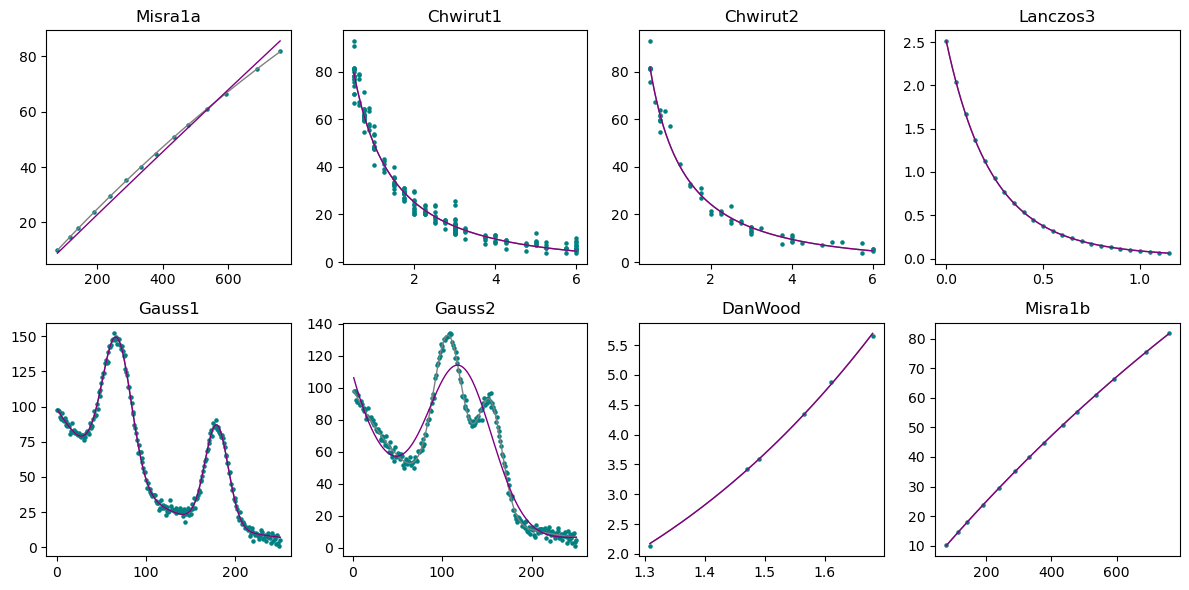

Average difficulty models:


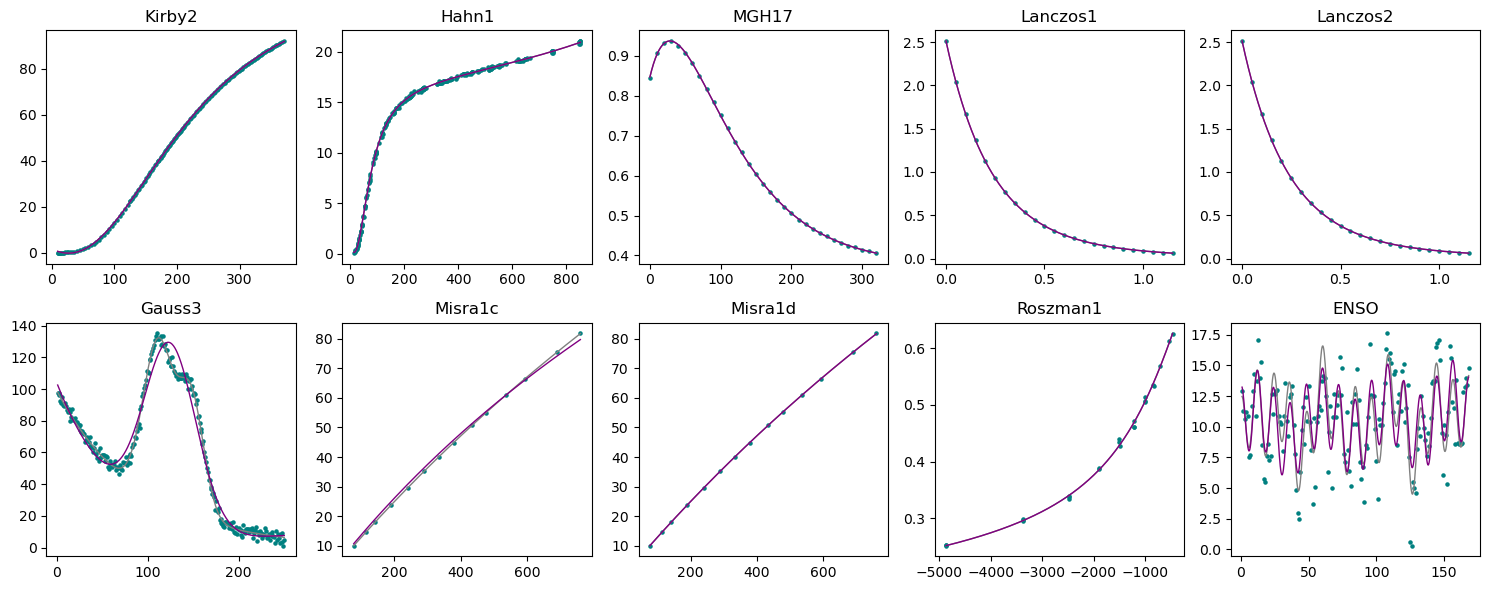

Higher difficulty models:


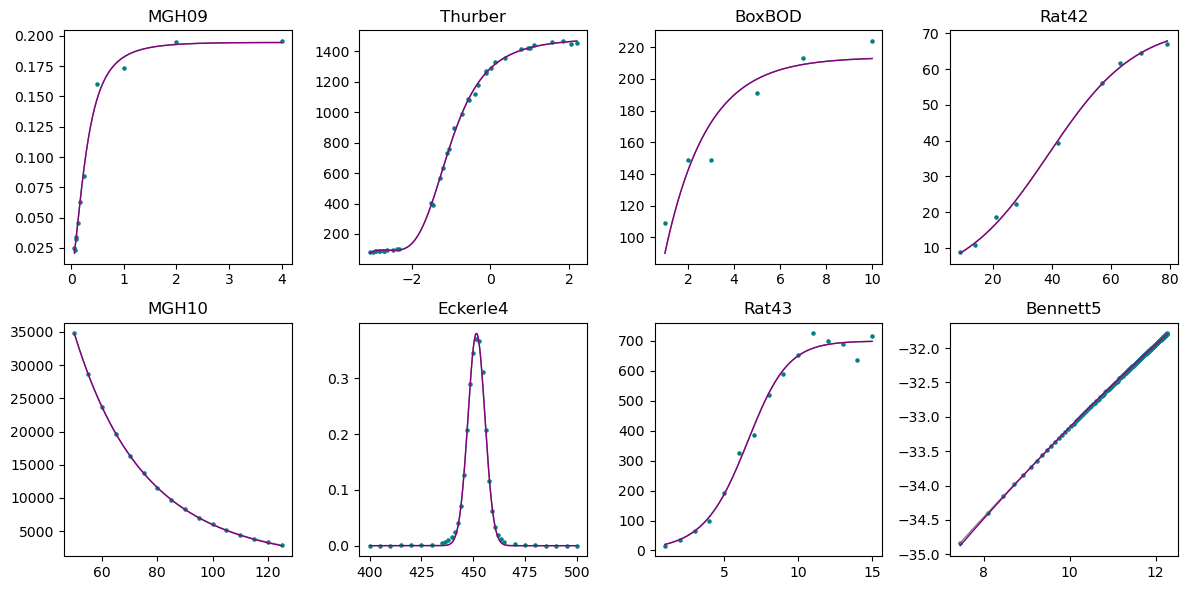

In [5]:
# Plot graphs of functions generated by the DEAMC algorithm for the NIST models

model_names = [
  # Lower difficulty
  ["Misra1a", "Chwirut1", "Chwirut2", "Lanczos3", "Gauss1", "Gauss2", "DanWood", "Misra1b"],
  # Average difficulty
  ["Kirby2", "Hahn1", "MGH17", "Lanczos1", "Lanczos2", "Gauss3", "Misra1c", "Misra1d", "Roszman1", "ENSO"],
  # Higher difficulty
  ["MGH09", "Thurber", "BoxBOD", "Rat42", "MGH10", "Eckerle4", "Rat43", "Bennett5"]
]
model_difficulties = ["Lower", "Average", "Higher"]
deamc_results = [[], [], []]

for batch in range(3):
  print(f"{model_difficulties[batch]} difficulty models:")
  if batch == 1:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  else:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

  for ax, title in zip(axes.flat, model_names[batch]):
    model = NISTModel(title)
    model_df = model.data()

    # Apply DEAMC algorithm to model
    xb, fb, nf, c = deamc_nist_model(title)
    deamc_results[batch].append((title, xb, fb, nf, c))

    # Plot model function with certified parameters
    x = np.linspace(min(model_df['x']), max(model_df['x']), 500)
    f = np.zeros(500)
    for i in range(500):
      f[i] = model.evaluate(x[i], model.get_certified_values())
    ax.plot(x, f, linewidth=1, color='grey')
    # Plot function generated by DEAMC
    f_deamc = np.zeros(500)
    for i in range(500):
      f_deamc[i] = model.evaluate(x[i], xb)
    ax.plot(x, f_deamc, linewidth=1, color='purple')
    # Plot observations
    ax.scatter(model_df['x'], model_df['y'], s=5, color='teal')
    ax.set_title(title)
  
  plt.tight_layout()
  plt.show()

### Evaluating convergence and experimental results
Next, I will perform experiments to compute the performance of the DEAMC algorithm on the selected datasets.  
To be able to compare my algorithm's performance to that of Wongsa, Puphasuk and Wetweerapong, I will perform 10 experiments for every model, and compute the following metrics:  
Let $fb$ be the best value obtained from an algorithm and $c$ be the certified value for a problem.  
- $\lambda$ value indicates the number of decimal places that fb matches the certified value
$$ \lambda = \begin{cases} 
    0 & \text{if } \frac{|fb - c|}{c} \geq 1 \\
    11 & \text{if } \frac{|fb - c|}{c} < 10^{-11} \\
    -\log_{10}\left(\frac{|fb - c|}{c}\right) & \text{otherwise}
  \end{cases} $$
- $NS$ is the number of successful runs, calculated as the number of runs where:
  - the algorithm reaches the threshold before exceeding the $maxnf$ (early convergence)
  - $\lambda > 4$
- Mean $nf$ represents the average number of evaluations of the algorithm over the 100 experiments.

In [40]:
# Metrics functions

def deamc_10_experiments(model_name: str):
  """
  Run 10 DEAMC experiments for a NIST model and return metrics:
  - NS: Number of successful runs (lamb >= 4 and converged)
  - mean_nf: Mean number of function evaluations
  - mean_lambda: Mean lambda (accuracy) across runs
  """
  model = NISTModel(model_name)
  certified_values = model.get_certified_values()
  NS = 0
  nf_values = []
  lambda_values = []

  for _ in range(10):
    xb, fb, nf, converged = deamc_nist_model(model_name)
    lamb = compute_lambda(xb, certified_values)
    
    nf_values.append(nf)
    lambda_values.append(lamb)
    if success(converged, lamb):
      NS += 1

  mean_nf = np.mean(nf_values) if nf_values else 0
  mean_lambda = np.mean(lambda_values) if lambda_values else 0
  return NS, mean_nf, mean_lambda

In [21]:
# Compute metrics for the algorithms and store them in markdown tables

model_names = [
  # Lower difficulty
  ["Misra1a", "Chwirut1", "Chwirut2", "Lanczos3", "Gauss1", "Gauss2", "DanWood", "Misra1b"],
  # Average difficulty
  ["Kirby2", "Hahn1", "MGH17", "Lanczos1", "Lanczos2", "Gauss3", "Misra1c", "Misra1d", "Roszman1", "ENSO"],
  # Higher difficulty
  ["MGH09", "Thurber", "BoxBOD", "Rat42", "MGH10", "Eckerle4", "Rat43", "Bennett5"]
]
tables = []

for batch in range(3):
  model_names_values = model_names[batch]
  NS_list = []
  mean_nf_list = []
  mean_lambda_list = []

  for model_name in model_names_values:
    NS, mean_nf, mean_lambda = deamc_10_experiments(model_name)

    NS_list.append(NS)
    mean_nf_list.append(mean_nf)
    mean_lambda_list.append(mean_lambda)

  header = "| Problem | NS | Mean nf | Mean λ |\n"
  header += "|---|---|---|---|\n"
  table = lists_to_markdown_table(header, model_names_values, NS_list, mean_nf_list, mean_lambda_list)
  tables.append(table)

## Table of obtained experimental results

### Lower difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Misra1a | 3 | 1448.0 | 2.449015380894176 |
| Chwirut1 | 9 | 3282.0 | 5.748090534987178 |
| Chwirut2 | 10 | 3474.0 | 6.286519230018664 |
| Lanczos3 | 6 | 55062.0 | 4.241919926605436 |
| Gauss1 | 8 | 32760.0 | 5.825460466202783 |
| Gauss2 | 1 | 35296.0 | 0.8555209945549944 |
| DanWood | 8 | 1722.0 | 6.49780514935747 |
| Misra1b | 4 | 1768.0 | 3.057827497018831 |

### Average difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Kirby2 | 10 | 10830.0 | 6.2545773641287905 |
| Hahn1 | 10 | 21756.0 | 5.814778700442284 |
| MGH17 | 10 | 15285.0 | 6.531340788641171 |
| Lanczos1 | 0 | 218676.0 | 6.699911693794325 |
| Lanczos2 | 2 | 44736.0 | 1.7160513232547605 |
| Gauss3 | 0 | 34432.0 | 0.0846031488610966 |
| Misra1c | 3 | 1750.0 | 2.476177475602486 |
| Misra1d | 3 | 1696.0 | 2.3719276567213483 |
| Roszman1 | 10 | 6620.0 | 6.513143551641086 |
| ENSO | 4 | 29565.0 | 2.679702950571749 |

### Higher difficulty
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| MGH09 | 10 | 6356.0 | 5.986913935360474 |
| Thurber | 7 | 23226.0 | 4.890812762817954 |
| BoxBOD | 10 | 1524.0 | 7.465298748003008 |
| Rat42 | 10 | 4170.0 | 7.457261132266433 |
| MGH10 | 10 | 18840.0 | 7.966186985766322 |
| Eckerle4 | 8 | 3141.0 | 7.610461113009083 |
| Rat43 | 10 | 6964.0 | 7.3109346847589025 |
| Bennett5 | 0 | 28758.0 | 0.15423753708988758 |

### Past experiment results

| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Misra1a | 4 | 1550.0 | 3.0128800100578625 |
| Chwirut1 | 10 | 3420.0 | 6.060057889293306 |
| Lanczos3 | 5 | 58308.0 | 3.537158354598259 |
| Gauss1 | 4 | 26936.0 | 2.9226720302463045 |
| DanWood | 6 | 1494.0 | 4.804842280430851 |
| Kirby2 | 10 | 10985.0 | 6.536159829516862 |
| MGH17 | 10 | 14820.0 | 6.243980396984648 |
| Lanczos1 | 0 | 29640.0 | 0.09366064699010357 |
| Misra1c | 3 | 1546.0 | 2.498285873480339 |
| Roszman1 | 10 | 6756.0 | 6.461049863373413 |
| Thurber | 9 | 23317.0 | 6.452229711197411 |
| Rat42 | 10 | 4062.0 | 7.399562335683347 |
| MGH10 | 10 | 17709.0 | 8.189990606719089 |
| Eckerle4 | 8 | 3093.0 | 7.381809585085401 |
| Bennett5 | 1 | 73551.0 | 1.2764681933464765 |

## Discussion on results
By comparing the results to those obtained by the authors (performed over 100 experiments):
| Problem | NS | Mean nf | Mean λ |
|---|---|---|---|
| Misra1a | 100 | 2,892 | 10.4 |
| Chwirut1 | 100 | 5,328 | 11.0 |
| Lanczos3 | 100 | 68,101 | 10.8 |
| Gauss1 | 100 | 28,562 | 10.7 |
| Danwood | 100 | 2,062 | 11.0 |
| Kirby2 | 100 | 15,537 | 11.0 |
| Mgh17 | 100 | 18,260 | 11.0 |
| Lanczos1 | 0 | 240,000 | 0.0 |
| Misra1c | 100 | 3,571 | 11.0 |
| Roszman1 | 100 | 6,734 | 11.0 |
| Thurber | 100 | 25,751 | 10.9 |
| Rat42 | 100 | 4,002 | 11.0 |
| Mgh10 | 100 | 39,696 | 11.0 |
| Eckerle4 | 100 | 2,995 | 10.7 |
| Bennett5 | 100 | 81,797 | 11.0 |  

We can reach the following conclusions:
- The algorithm generally performs well, yielding maximum successful runs for 6 out of 15 experiments.
- The algorithm handles complex data very well, perhaps even better than simple data. This indicates that it is more suitable for complex regression problems.
- For easier models, the reason for lower performance may be overfitting. In this case, we can try to modify the rate of adaptation for balancing exploration and exploitation.
- For overall better performance, we might consider adjusting the multiplier factor for initial value bounds, so that the solution search space is larger or narrower, depending on need.

## References
- R. Storn and K. Price, *Differential Evolution–A simple and efficient heuristic for global optimization over continuous spaces*, Journal of Global Optimization, vol. 11, no. 4, pp. 341-359, 1997, doi: 10.1023/A:1008202821328.

- Wongsa, Watchara & Puphasuk, Pikul & Wetweerapong, Jeerayut. (2024). *Differential evolution with adaptive mutation and crossover strategies for nonlinear regression problems*. Bulletin of Electrical Engineering and Informatics. 13. 3503-3514. 10.11591/eei.v13i5.6417. 